<a href="https://colab.research.google.com/github/azizahfzahr/Fish-Freshness-Classification-Using-CNN-VGG16-Transfer-Learning/blob/main/Rev3_CNN_VGG_Dataset_Gabungan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **JUDUL SKRIPSI : KLASIFIKASI KESEGARAN IKAN BERDASARKAN CITRA INSANG MENGGUNAKAN CONVOLUTIONAL NEURAL NETWORK DAN TRANSFER LEARNING**

## **1. Menyiapkan library yang akan digunakan**

In [ ]:
import tensorflow as tf
import pathlib
import matplotlib.pyplot as plt
import os
import numpy as np
import shutil
import tensorflow_hub as hub
import itertools
from six.moves import urllib
from os.path import join, exists
from google.colab import drive
from tensorflow import keras
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from tensorflow.keras.applications import VGG16, DenseNet121
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image
from skimage import transform
from tqdm.notebook import tqdm_notebook
from enum import Enum

## **2. Menyambungkan google drive berisi dataset ke dalam program**

In [ ]:
drive.mount('/content/gdrive')
ROOT_PATH = '/content/gdrive/My Drive/Colab Notebooks/Dataset Gabungan/'
fresh = '/content/gdrive/My Drive/Colab Notebooks/Dataset Gabungan/train/fresh'
non_fresh = '/content/gdrive/My Drive/Colab Notebooks/Dataset Gabungan/train/non fresh'
print("Total fresh: ", os.listdir(fresh))
print("Total non fresh: ", os.listdir(non_fresh))

Mounted at /content/gdrive
Total fresh:  ['train-v1-insang-fresh  (401).jpg', 'train-v1-insang-fresh  (386).jpg', 'train-v1-insang-fresh  (396).jpg', 'train-v1-insang-fresh  (378).jpg', 'train-v1-insang-fresh  (398).jpg', 'train-v1-insang-fresh  (388).jpg', 'train-v1-insang-fresh  (411).jpg', 'train-v1-insang-fresh  (419).jpg', 'train-v1-insang-fresh  (433).jpg', 'train-v1-insang-fresh  (424).jpg', 'train-v1-insang-fresh  (385).jpg', 'train-v1-insang-fresh  (393).jpg', 'train-v1-insang-fresh  (383).jpg', 'train-v1-insang-fresh  (409).jpg', 'train-v1-insang-fresh  (391).jpg', 'train-v1-insang-fresh  (404).jpg', 'train-v1-insang-fresh  (394).jpg', 'train-v1-insang-fresh  (435).jpg', 'train-v1-insang-fresh  (427).jpg', 'train-v1-insang-fresh  (399).jpg', 'train-v1-insang-fresh  (379).jpg', 'train-v1-insang-fresh  (35).jpg', 'train-v1-insang-fresh  (430).jpg', 'train-v1-insang-fresh  (362).jpg', 'train-v1-insang-fresh  (367).jpg', 'train-v1-insang-fresh  (376).jpg', 'train-v1-insang-fresh 

## **3. Preprocessing Data**

In [ ]:
# Fungsi untuk memuat gambar dan mengubah ukurannya menjadi 60x60 piksel
def load(filename):
    np_image = Image.open(filename)
    np_image = np.array(np_image).astype('float32') / 255
    np_image = transform.resize(np_image, (60, 60, 3))
    np_image = np.expand_dims(np_image, axis=0)
    return np_image

# Input citra baru
input_size = (224, 224, 3)

# Ukuran batch baru
batch_size = 256

# Initializing generator for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,
    rotation_range=20,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest",
)

# Initializing generator for validation data
val_datagen = ImageDataGenerator(rescale=1./255)

# Initializing generator for test data
test_datagen = ImageDataGenerator(rescale=1./255)

# Defining paths for train, validation, and test directories
train_dir = '/content/gdrive/My Drive/Colab Notebooks/Dataset Gabungan/train'
val_dir = '/content/gdrive/My Drive/Colab Notebooks/Dataset Gabungan/val'
test_dir = '/content/gdrive/My Drive/Colab Notebooks/Dataset Gabungan/test'

# Creating train generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Input image dimensions
    batch_size=256,
    class_mode='binary'
)

# Creating validation generator
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),  # Input image dimensions
    batch_size=256,
    class_mode='binary'
)

# Creating test generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),  # Input image dimensions
    batch_size=1,
    class_mode='binary',
    shuffle=False
)

# Check for Class Imbalance
print("Training set class distribution:", np.bincount(train_generator.classes))
print("Validation set class distribution:", np.bincount(val_generator.classes))
print("Test set class distribution:", np.bincount(test_generator.classes))

# Simpan augmented images ke direktori "preview"
preview_dir = 'preview'
os.makedirs(preview_dir, exist_ok=True)  # Membuat direktori "preview" jika belum ada

Found 3200 images belonging to 2 classes.
Found 527 images belonging to 2 classes.
Found 272 images belonging to 2 classes.
Training set class distribution: [1607 1593]
Validation set class distribution: [244 283]
Test set class distribution: [136 136]


# **CNN**

## **4. Membuat model CNN**

In [ ]:
# Define the number of classes
num_class = 1

cnn_model3 = Sequential()

# the first convolutional block
cnn_model3.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_size))
# max pooling
cnn_model3.add(MaxPooling2D(pool_size=(2, 2)))

# the second convolutional block
cnn_model3.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
# max pooling
cnn_model3.add(MaxPooling2D(pool_size=(2, 2)))

# the third convolutional block
cnn_model3.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
# max pooling
cnn_model3.add(MaxPooling2D(pool_size=(2, 2)))

# flatten
cnn_model3.add(Flatten())

# fully connected layer
cnn_model3.add(Dense(128, activation='relu'))

# last layer
cnn_model3.add(Dense(num_class, activation='sigmoid'))

# Compile the model
cnn_model3.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
cnn_model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 28, 28, 128)       0

## **5. Compiling Model CNN**

In [ ]:
# Path to save the best model.
checkpoint_filepath = join(ROOT_PATH, 'cnn_model3.h5')

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath, save_weights_only=False,
    monitor='val_loss', verbose=1, mode='auto', save_best_only=True)

opt = keras.optimizers.Adam(learning_rate=1e-3)

cnn_model3.compile(optimizer=opt,
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

In [ ]:
cnn_model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 28, 28, 128)       0

## **6. Fitting Model CNN**

In [ ]:
epochs = 15

history = cnn_model3.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[model_checkpoint_callback],
    verbose=1)

Epoch 1/15
13/13 [==============================] - ETA: 0s - loss: 0.8028 - accuracy: 0.5216  
Epoch 1: val_loss improved from inf to 0.68318, saving model to /content/gdrive/My Drive/Colab Notebooks/Dataset Gabungan/cnn_model3.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - 1227s 98s/step - loss: 0.8028 - accuracy: 0.5216 - val_loss: 0.6832 - val_accuracy: 0.5370
Epoch 2/15
13/13 [==============================] - ETA: 0s - loss: 0.6891 - accuracy: 0.5556 
Epoch 2: val_loss improved from 0.68318 to 0.68181, saving model to /content/gdrive/My Drive/Colab Notebooks/Dataset Gabungan/cnn_model3.h5
13/13 [==============================] - 478s 36s/step - loss: 0.6891 - accuracy: 0.5556 - val_loss: 0.6818 - val_accuracy: 0.6167
Epoch 3/15
13/13 [==============================] - ETA: 0s - loss: 0.6548 - accuracy: 0.6103 
Epoch 3: val_loss improved from 0.68181 to 0.57347, saving model to /content/gdrive/My Drive/Colab Notebooks/Dataset Gabungan/cnn_model3.h5
13/13 [==============================] - 482s 36s/step - loss: 0.6548 - accuracy: 0.6103 - val_loss: 0.5735 - val_accuracy: 0.7875
Epoch 4/15
13/13 [==============================] - ETA: 0s - loss: 0.6127 - accuracy: 0.6612 
Epoch 4: val_loss improved from 0.57347 t

## **7. Grafik Hasil Train Model CNN**

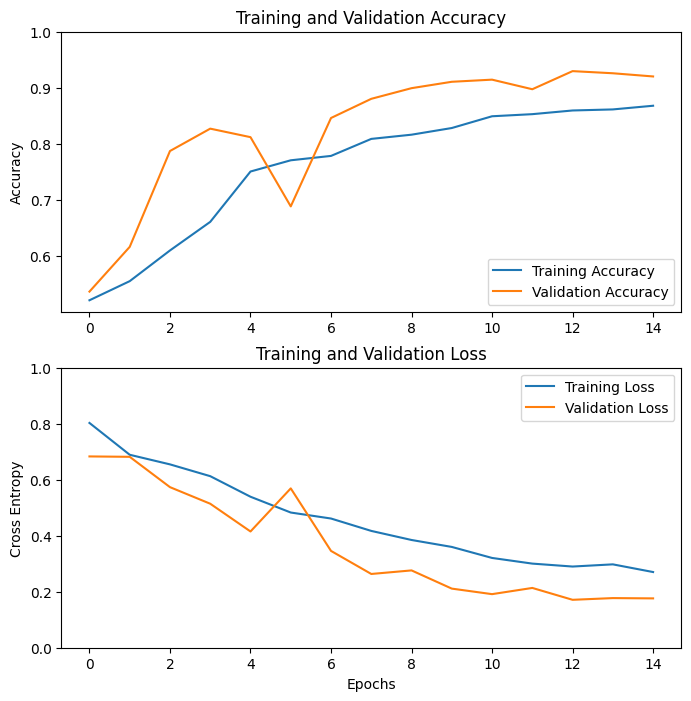

In [ ]:
# Assume history is already defined and contains the relevant training statistics
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Define the correct range for epochs
epochs_range = range(len(acc))

# Plot training and validation accuracy
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

# Plot training and validation loss
plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 1.0])
plt.xlabel('Epochs')
plt.title('Training and Validation Loss')
plt.show()

## **8. Evaluasi model CNN**

In [ ]:
# load hasil pelatihan untuk di uji
trained_model = load_model(checkpoint_filepath)

# pengujian dengan data uji
trained_model.evaluate(test_generator, verbose=1)

272/272 [==============================] - 135s 497ms/step - loss: 0.2145 - accuracy: 0.8897


[0.21454592049121857, 0.8897058963775635]

In [ ]:
# Prediksi dengan data uji
y_predict = (trained_model.predict(test_generator) > 0.5).astype("int32")

# Dapatkan label aktual dari data uji
y_actual = test_generator.classes

# Nama kelas dari generator
class_names = list(test_generator.class_indices.keys())

272/272 [==============================] - 13s 46ms/step


## **9. Confusion Matrix Model CNN**

Laporan Klasifikasi Data Uji:
              precision    recall  f1-score   support

           0       0.86      0.93      0.89       136
           1       0.93      0.85      0.88       136

    accuracy                           0.89       272
   macro avg       0.89      0.89      0.89       272
weighted avg       0.89      0.89      0.89       272

Confusion Matrix:
[[127   9]
 [ 21 115]]


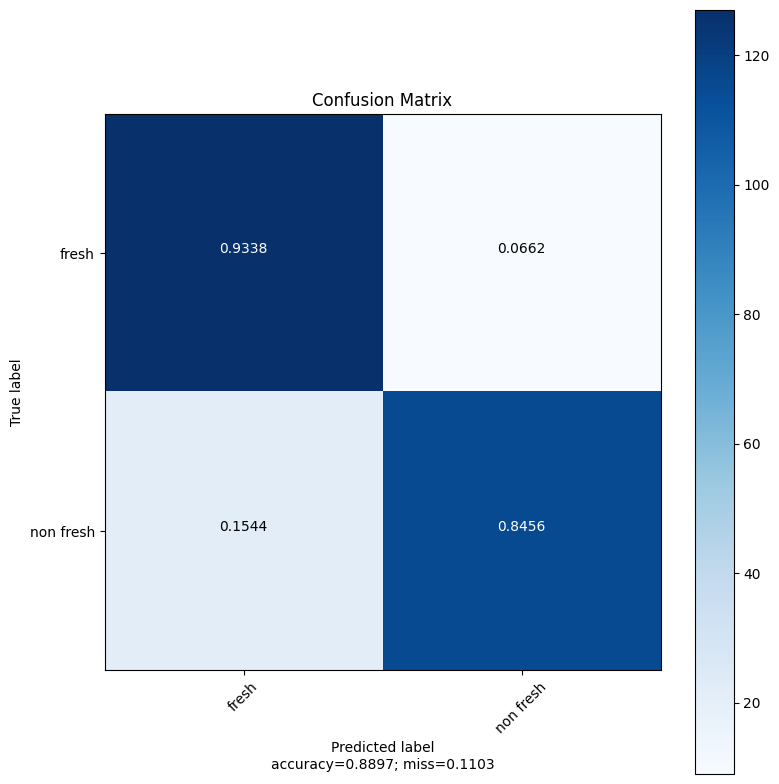

In [ ]:
# cetak laporan hasil klasifikasi data uji
print('Laporan Klasifikasi Data Uji:')
print(classification_report(y_actual, y_predict))

# hitung confusion matrixnya
conf_mat_result = confusion_matrix(y_actual, y_predict)

# cetak confusion matrix
print('Confusion Matrix:')
print(conf_mat_result)

accuracy = np.trace(conf_mat_result) / np.sum(conf_mat_result).astype('float')
misclass = 1 - accuracy

# masukkan nama kelas di dataset
target_names = class_names
plt.figure(figsize=(8, 8))
cmap = plt.get_cmap('Blues')

plt.imshow(conf_mat_result, interpolation='nearest', cmap=cmap)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)

cm = conf_mat_result.astype('float') / conf_mat_result.sum(axis=1)[:, np.newaxis]
thresh = cm.max() / 1.5
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, "{:0.4f}".format(cm[i, j]),
        horizontalalignment='center',
        color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label\naccuracy={:0.4f}; miss={:0.4f}'.format(accuracy, misclass))
plt.show()

# **VGG-16**

## **10. Load Pre-trained VGG-16**

In [ ]:
# Memuat model VGG16 dengan bobot yang telah di pre-trained
model = VGG16(weights='imagenet')

# Menampilkan ringkasan model
model.summary()

# Menampilkan informasi lebih mendetail tentang setiap layer
for i, layer in enumerate(model.layers):
    print(f"Layer {i}: {layer.name}, Type: {layer.__class__.__name__}")

553467096/553467096 [==============================] - 13s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

In [ ]:
# nama model yang akan digunakan
class MODEL(Enum):
    TF_VGG16 = 1

opt_model = MODEL.TF_VGG16

# jumlah epoch pelatihan
epochs = 15

In [ ]:
# Pilih base model
if opt_model == MODEL.TF_VGG16:
    # Lokasi untuk menyimpan hasil pelatihan
    checkpoint_filepath = join(ROOT_PATH, 'vgg16_model_pt3.h5')

## **11. Feature Extraction Pre-Trained VGG-16**

In [ ]:
# Memuat model VGG16 dengan bobot yang telah dipra-latih
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Membekukan semua layer dalam base_model
for layer in base_model.layers:
    layer.trainable = False

# Menambahkan layer tambahan untuk klasifikasi
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# Membuat model baru
model = Model(inputs=base_model.input, outputs=predictions)

# Mengkompilasi model
model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

# Menampilkan ringkasan model standar
model.summary()

# Menampilkan informasi lebih mendetail tentang setiap layer termasuk status "frozen"
for i, layer in enumerate(model.layers):
    trainable_status = "trainable" if layer.trainable else "frozen"
    print(f"Layer {i}: {layer.name}, Type: {layer.__class__.__name__}, Status: {trainable_status}")

58889256/58889256 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
checkpoint_filepath = '/content/gdrive/My Drive/Colab Notebooks/Dataset Gabungan/vgg16_model_pt3.h5'

## **13. Memodifikasi Model VGG-16 Untuk Tugas Kedua**

## **14. Train Model VGG-16**

In [ ]:
# pilih optimizer dan compile modelnya
init_learning_rate = 1e-3
opt_optimizer = Adam(learning_rate=init_learning_rate)
model.compile(optimizer=opt_optimizer,
                   loss='binary_crossentropy',
                   loss_weights=1.0,
                   metrics=['accuracy'])
model.summary() # menampilkan summary dari model yang dibuat

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## **15. Menentukan batas untuk callback, melakukan training dan menyimpan model**

In [ ]:
# Define the custom callback for early stopping based on accuracy
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_accuracy') > 0.92 and logs.get('accuracy') > 0.92:
            print("\nReached 92% val accuracy and accuracy, so cancelling training!")
            self.model.stop_training = True

# Path to save the best model
checkpoint_filepath = '/content/gdrive/My Drive/Colab Notebooks/Dataset Gabungan/vgg16_model_pt3.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    verbose=2,
    mode='auto',
    save_best_only=True
)

# Instantiate the custom callback
callbacks = myCallback()

# Train the model with the corrected configuration
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    verbose=1,
    callbacks=[model_checkpoint_callback, callbacks]
)

Epoch 1/15
13/13 [==============================] - ETA: 0s - loss: 2.4247 - accuracy: 0.5744  
Epoch 1: val_loss improved from inf to 0.37616, saving model to /content/gdrive/My Drive/Colab Notebooks/Dataset Gabungan/vgg16_model_pt3.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - 2495s 192s/step - loss: 2.4247 - accuracy: 0.5744 - val_loss: 0.3762 - val_accuracy: 0.8121
Epoch 2/15
13/13 [==============================] - ETA: 0s - loss: 0.4918 - accuracy: 0.7531  
Epoch 2: val_loss improved from 0.37616 to 0.25383, saving model to /content/gdrive/My Drive/Colab Notebooks/Dataset Gabungan/vgg16_model_pt3.h5
13/13 [==============================] - 2526s 195s/step - loss: 0.4918 - accuracy: 0.7531 - val_loss: 0.2538 - val_accuracy: 0.8672
Epoch 3/15
13/13 [==============================] - ETA: 0s - loss: 0.3487 - accuracy: 0.8291  
Epoch 3: val_loss improved from 0.25383 to 0.19744, saving model to /content/gdrive/My Drive/Colab Notebooks/Dataset Gabungan/vgg16_model_pt3.h5
13/13 [==============================] - 2565s 198s/step - loss: 0.3487 - accuracy: 0.8291 - val_loss: 0.1974 - val_accuracy: 0.8994
Epoch 4/15
13/13 [==============================] - ETA: 0s - loss: 0.2964 - accuracy: 0.8691  
Epoch 4: val_loss impro

## **16. Grafik Hasil Train Model VGG-16**

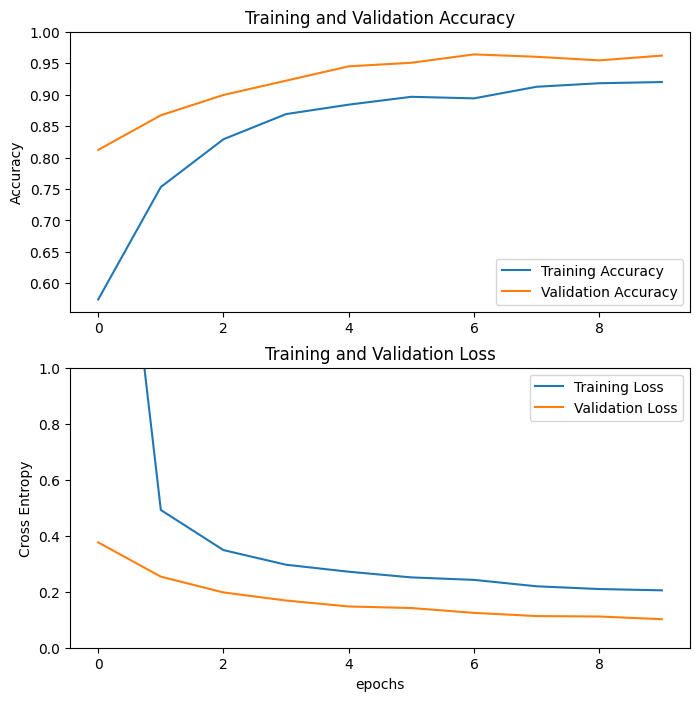

In [ ]:
# ambil statistik pelatihan
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(10)

# plot hasil akurasi pelatihan
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

# plot hasil loss pelatihan
plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.xlabel('epochs')
plt.title('Training and Validation Loss')
plt.show()

## **17. Evaluasi Model VGG-16**

In [ ]:
# load hasil pelatihan untuk di uji
trained_model = load_model(checkpoint_filepath)

# pengujian dengan data uji
trained_model.evaluate(test_generator, verbose=1)

272/272 [==============================] - 194s 713ms/step - loss: 0.1369 - accuracy: 0.9375


[0.13686764240264893, 0.9375]

In [ ]:
# Prediksi dengan data uji
y_predict = (trained_model.predict(test_generator) > 0.5).astype("int32")

# Dapatkan label aktual dari data uji
y_actual = test_generator.classes

# Nama kelas dari generator
class_names = list(test_generator.class_indices.keys())

272/272 [==============================] - 183s 669ms/step


## **18. Confusion Matrix Model VGG-16**

Laporan Klasifikasi Data Uji:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       136
           1       0.99      0.88      0.93       136

    accuracy                           0.94       272
   macro avg       0.94      0.94      0.94       272
weighted avg       0.94      0.94      0.94       272

Confusion Matrix:
[[135   1]
 [ 16 120]]


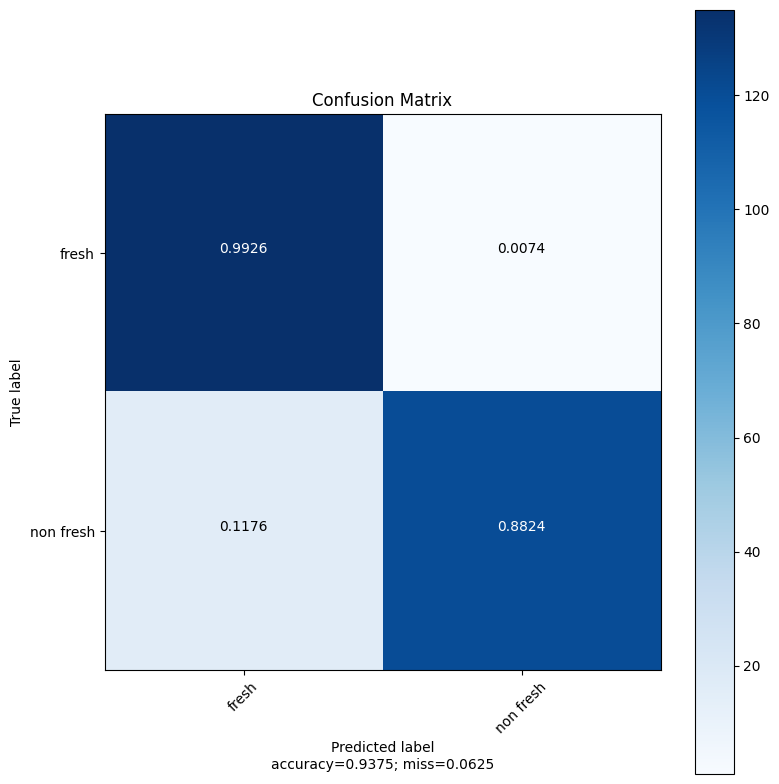

In [ ]:
# cetak laporan hasil klasifikasi data uji
print('Laporan Klasifikasi Data Uji:')
print(classification_report(y_actual, y_predict))

# hitung confusion matrixnya
conf_mat_result = confusion_matrix(y_actual, y_predict)

# cetak confusion matrix
print('Confusion Matrix:')
print(conf_mat_result)

accuracy = np.trace(conf_mat_result) / np.sum(conf_mat_result).astype('float')
misclass = 1 - accuracy

# masukkan nama kelas di dataset
target_names = class_names
plt.figure(figsize=(8, 8))
cmap = plt.get_cmap('Blues')

plt.imshow(conf_mat_result, interpolation='nearest', cmap=cmap)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)

cm = conf_mat_result.astype('float') / conf_mat_result.sum(axis=1)[:, np.newaxis]
thresh = cm.max() / 1.5
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, "{:0.4f}".format(cm[i, j]),
        horizontalalignment='center',
        color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label\naccuracy={:0.4f}; miss={:0.4f}'.format(accuracy, misclass))
plt.show()